In [1]:
import arff
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from sklearn.metrics import classification_report, precision_score
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source

In [2]:
# Define a function to fill NaN with the mean of the column for the respective BANKRUPTCY_FLAG group
def fillna_with_group_mean(df, column, flag):
    mean_value = df[df['BANKRUPTCY_FLAG'] == flag][column].mean()
    df.loc[df['BANKRUPTCY_FLAG'] == flag, column] = df.loc[df['BANKRUPTCY_FLAG'] == flag, column].fillna(mean_value)
    return df

## Section 1: Importing Data
data source...


In [3]:
df = pd.DataFrame()


# Read Annual Files downloaded from https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data
for i in [x for x in os.listdir() if x.find('.arff')!=-1]:

    temp_df = pd.DataFrame(arff.loadarff(i)[0])

    temp_df['dataset']=i
    df = pd.concat([df,temp_df])

# Change Column Header Names to respective Financial Ratio, Excel Manually Compiled from Read Me.
column_data = pd.read_excel('polish_company_data.xlsx')

column_data['COLUMN_NAME'] = column_data['COLUMN_NAME'].apply(lambda x:x.replace('X','Attr'))
column_data.loc[64,'COLUMN_NAME']='class'
column_data.loc[64,'FINANCIAL_RATIO']='BANKRUPTCY_FLAG'

df = df.rename(columns={column_data['COLUMN_NAME'].tolist()[x]:column_data['FINANCIAL_RATIO'].tolist()[x] for x in range(len(column_data['COLUMN_NAME']))})
# Convert Bankruptcy Flag into INT.
df['BANKRUPTCY_FLAG'] = df['BANKRUPTCY_FLAG'].apply(lambda x:int(x))


# Create a list of original column names, supports visualizations utilized below
og_columns = [x for x in df.columns if x not in ['dataset']]
og_predict_columns = og_columns.copy()
og_predict_columns.remove('BANKRUPTCY_FLAG')
df = df.drop(columns=['dataset'])

# Count the number of 0 values
count_zeros = (df['BANKRUPTCY_FLAG'] == 0).sum()

# Count the number of 1 values
count_ones = (df['BANKRUPTCY_FLAG'] == 1).sum()

print(f"Number of 0 values: {count_zeros}")
print(f"Number of 1 values: {count_ones}")


Number of 0 values: 41314
Number of 1 values: 2091


## Resample
### Number of sample is significanly imbalance, which may lead to model bias towards the majority class. Try resample

## Section 2: EDA



## compare difference between 0 and 1

## Section 3: Data clearning and group features if they are strongly correlated. 

Group 1: -working capital / total assets, +total liabilities / total assets, -retained earnings / total assets, -short-term liabilities / total assets
Group 2: +(gross profit + extraordinary items + financial expenses) / total assets, +EBIT / total assets, +(gross profit + interest) / total assets, +gross profit / total assets, +profit on operating activities / total assets, +gross profit (in 3 years) / total assets, +operating expenses / short-term liabilities, +operating expenses / total liabilities, +profit on sales / total assets, +total sales / total assets, +EBITDA (profit on operating activities - depreciation) / total assets, +sales / short-term liabilities
Group 3: +(gross profit + depreciation) / total liabilities, +gross profit / short-term liabilities, +(net profit + depreciation) / total liabilities
Group 4: +total assets / total liabilities, +book value of equity / total liabilities
Group 5: +net profit / sales, +gross profit / sales, +(gross profit + interest) / sales
Gr

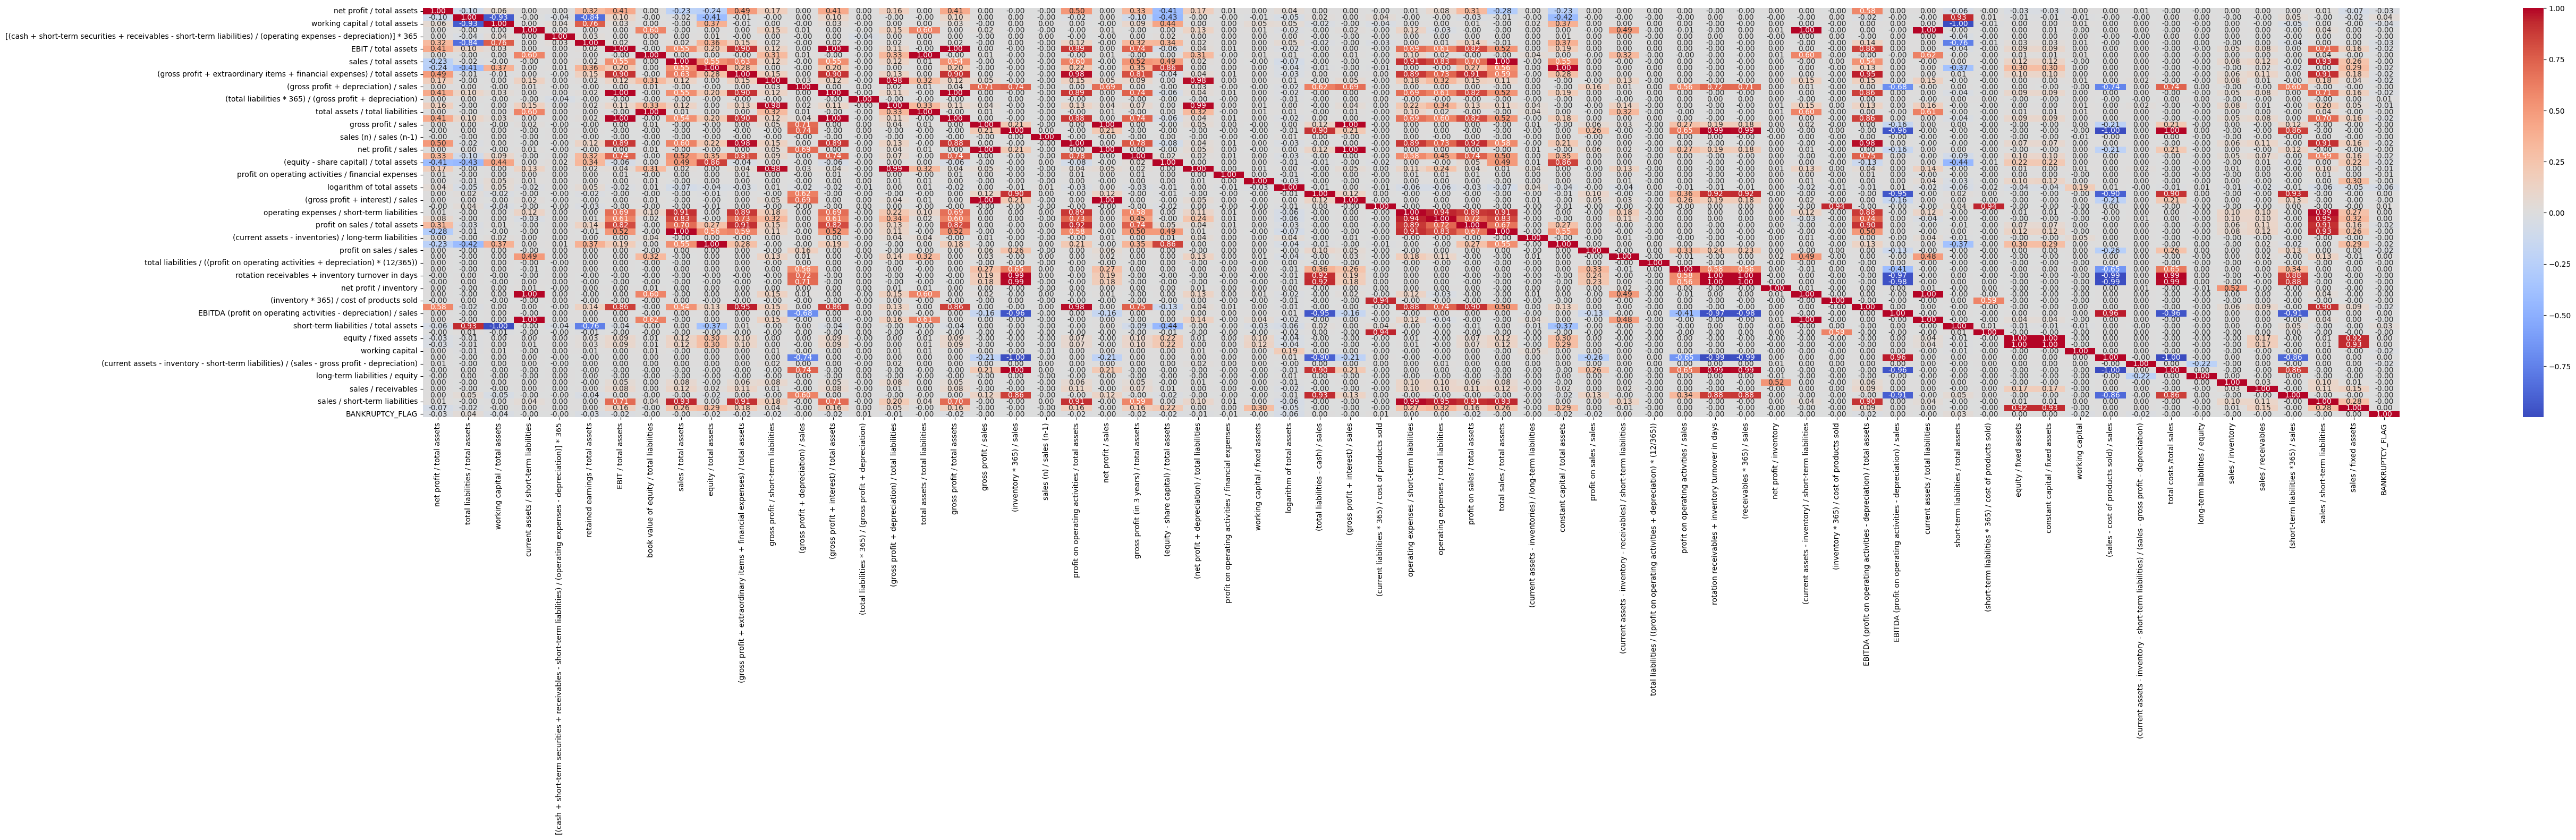

In [4]:

# Step 1: Calculate the correlation matrix
correlation_matrix = df.corr()

# Step 2: Set a threshold for strong correlation
threshold = 0.75  # This is an test threshold

# Step 3: Find pairs and group them, indicating the sign of correlation
correlated_groups = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            # Determine the sign of the correlation
            sign = '+' if correlation_matrix.iloc[i, j] > 0 else '-'

            # Check if the feature is already in a group
            found = False
            for group in correlated_groups:
                if colname_i in group or colname_j in group:
                    group.update({colname_i: sign, colname_j: sign})
                    found = True
                    break
            if not found:
                correlated_groups.append({colname_i: sign, colname_j: sign})

# Print out the groups of correlated features with group names and signs
for index, group in enumerate(correlated_groups, start=1):
    group_str = ", ".join(f"{sign}{name}" for name, sign in group.items())
    print(f"Group {index}: {group_str}")

# Optional: visualize the correlation matrix
plt.figure(figsize=(60, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


### Data cleaning

In [ ]:
df

## Remove the feature if they have strong correlation


In [5]:

# Step 1: Calculate the correlation matrix
correlation_matrix = df.corr().abs()

# Step 2: Create a boolean mask for correlations above 90%
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))

# Step 3: Find index/column names for highly correlated features
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Step 4: Drop the marked features
df_reduced = df.drop(columns=to_drop)
# df_reduced = df.copy()

# Print out the features that will be dropped
print(f"Features to be dropped due to high correlation (> 90%): {to_drop}")

# Print out the remaining features
print(f"Remaining features: {df_reduced.columns.tolist()}")


Features to be dropped due to high correlation (> 90%): ['working capital / total assets', 'retained earnings / total assets', '(gross profit + extraordinary items + financial expenses) / total assets', '(gross profit + interest) / total assets', '(gross profit + depreciation) / total liabilities', 'total assets / total liabilities', 'gross profit / total assets', 'profit on operating activities / total assets', 'net profit / sales', 'gross profit (in 3 years) / total assets', '(equity - share capital) / total assets', '(net profit + depreciation) / total liabilities', '(total liabilities - cash) / sales', '(gross profit + interest) / sales', 'operating expenses / short-term liabilities', 'operating expenses / total liabilities', 'profit on sales / total assets', 'total sales / total assets', 'constant capital / total assets', 'rotation receivables + inventory turnover in days', '(receivables * 365) / sales', '(current assets - inventory) / short-term liabilities', '(inventory * 365) /

In [6]:
# Count the number of 0 values
count_zeros = (df_reduced['BANKRUPTCY_FLAG'] == 0).sum()

# Count the number of 1 values
count_ones = (df_reduced['BANKRUPTCY_FLAG'] == 1).sum()

print(f"Number of 0 values: {count_zeros}")
print(f"Number of 1 values: {count_ones}")


Number of 0 values: 41314
Number of 1 values: 2091


### Drop outliners

In [ ]:
# print(len(df_reduced.columns))
# print(len(df.columns))
# # Assuming 'df' is your DataFrame and you want to apply this to all numeric columns
# for column in df.select_dtypes(include=np.number).columns:
#     # Calculate the IQR (Interquartile Range)
#     if column == 'BANKRUPTCY_FLAG':
#         print(f"Skipping {column}")
        
#         continue  # Skip the outlier detection for 'BANKRUPTCY_FLAG'

#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Define outliers as those beyond 1.5 times the IQR from the Q1 or Q3
#     lower_bound = Q1 - 3 * IQR
#     upper_bound = Q3 + 3 * IQR
    
#     # Identify outliers
#     outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
#     # Print the percentage of data that are outliers for the column
#     percent_outliers = len(outliers) / len(df) * 100
#     print(f"{column}: {percent_outliers:.2f}% outliers")
    
#     # Option 1: Remove outliers
#     df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
#     # Option 2: Cap outliers
#     # df.loc[df[column] < lower_bound, column] = lower_bound
#     # df.loc[df[column] > upper_bound, column] = upper_bound

In [7]:
# Count the number of rows with any NaN values when BANKRUPTCY_FLAG = 0
na_count_0 = df[df['BANKRUPTCY_FLAG'] == 0].isna().any(axis=1).sum()/count_zeros*100

# Count the number of rows with any NaN values when BANKRUPTCY_FLAG = 1
na_count_1 = df[df['BANKRUPTCY_FLAG'] == 1].isna().any(axis=1).sum()/count_ones*100

print(f"Number of rows with NaNs when BANKRUPTCY_FLAG = 0: {na_count_0:.2f}%")
print(f"Number of rows with NaNs when BANKRUPTCY_FLAG = 1: {na_count_1:.2f}%")

Number of rows with NaNs when BANKRUPTCY_FLAG = 0: 52.72%
Number of rows with NaNs when BANKRUPTCY_FLAG = 1: 79.34%


In [8]:
# Apply the function to each column (excluding the 'BANKRUPTCY_FLAG' column)
for column in df.columns.difference(['BANKRUPTCY_FLAG']):
    df = fillna_with_group_mean(df, column, 0)
    df = fillna_with_group_mean(df, column, 1)


In [9]:
# Count the number of rows with any NaN values when BANKRUPTCY_FLAG = 0
na_count_0 = df[df['BANKRUPTCY_FLAG'] == 0].isna().any(axis=1).sum()/count_zeros*100

# Count the number of rows with any NaN values when BANKRUPTCY_FLAG = 1
na_count_1 = df[df['BANKRUPTCY_FLAG'] == 1].isna().any(axis=1).sum()/count_ones*100

print(f"Number of rows with NaNs when BANKRUPTCY_FLAG = 0: {na_count_0:.2f}%")
print(f"Number of rows with NaNs when BANKRUPTCY_FLAG = 1: {na_count_1:.2f}%")

Number of rows with NaNs when BANKRUPTCY_FLAG = 0: 0.00%
Number of rows with NaNs when BANKRUPTCY_FLAG = 1: 0.00%


In [10]:
# Calculate the correlation matrix for the reduced DataFrame (without taking the absolute value)
correlation_matrix_reduced_non_abs = df_reduced.corr()

# Calculate the absolute correlation matrix for the threshold mask
correlation_matrix_reduced = correlation_matrix_reduced_non_abs.abs()

# Set the threshold for high correlation to 70%
threshold_high = 0.4

# Create a mask for correlations above the threshold in the reduced correlation matrix
high_corr_mask_reduced = correlation_matrix_reduced > threshold_high

# Initialize a dictionary to hold the groups of correlated features
feature_groups_reduced = {}
group_number = 1

# Iterate over the columns of the reduced correlation matrix
for i in range(len(high_corr_mask_reduced.columns)):
    # Check if the feature is already part of a group
    if not any(high_corr_mask_reduced.columns[i] in group for group in feature_groups_reduced.values()):
        # Find features that are highly correlated with the current feature
        correlated_features = list(high_corr_mask_reduced.index[high_corr_mask_reduced.iloc[:, i]])
        # Remove the feature itself from the list
        correlated_features = [feat for feat in correlated_features if feat != high_corr_mask_reduced.columns[i]]
        # Only consider features that have not been grouped yet
        correlated_features = [feat for feat in correlated_features if not any(feat in group for group in feature_groups_reduced.values())]
        if correlated_features:
            # Assign the group number to the current set of correlated features
            feature_groups_reduced[group_number] = correlated_features + [high_corr_mask_reduced.columns[i]]
            group_number += 1

# Print out the groups of correlated features with signs
print("Groups of correlated features after dropping features with >90% correlation and with signs relative to 'net_profit_total_assets':\n")
for group_num, group_features in feature_groups_reduced.items():
    signed_group_features = []
    for feature in group_features:
        # Determine the sign of the correlation with 'net_profit_total_assets'
        sign = '+' if correlation_matrix_reduced_non_abs.at[feature, 'net profit / total assets'] >= 0 else '-'
        signed_group_features.append(f"{sign}{feature}")
    print(f"Group {group_num}: {signed_group_features}")


Groups of correlated features after dropping features with >90% correlation and with signs relative to 'net_profit_total_assets':

Group 1: ['+EBIT / total assets', '+net profit / total assets']
Group 2: ['-equity / total assets', '-total liabilities / total assets']
Group 3: ['+book value of equity / total liabilities', '+(current assets - inventory - receivables) / short-term liabilities', '+current assets / short-term liabilities']
Group 4: ['+gross profit / sales', '-(inventory * 365) / sales', '+profit on operating activities / sales', '+(gross profit + depreciation) / sales']
Group 5: ['+sales / inventory', '+net profit / inventory']


In [11]:
feature_groups_reduced
# List of feature groups
feature_groups = feature_groups_reduced
# Check for NaN values in each feature
nan_features = {}
for group, features in feature_groups.items():
    nan_features[group] = [feature for feature in features if df[feature].isna().any()]

# Print out the features that contain NaN values
for group, features_with_nans in nan_features.items():
    if features_with_nans:
        print(f"{group} features with NaN values: {features_with_nans}")
    else:
        print(f"{group} has no features with NaN values.")

# Calculate and print the percentage of NaN values for each feature
for group, features in feature_groups.items():
    print(f"NaN Percentage in {group}:")
    for feature in features:
        nan_percentage = df[feature].isna().sum() / len(df) * 100
        print(f"{feature}: {nan_percentage:.2f}%")


1 has no features with NaN values.
2 has no features with NaN values.
3 has no features with NaN values.
4 has no features with NaN values.
5 has no features with NaN values.
NaN Percentage in 1:
EBIT / total assets: 0.00%
net profit / total assets: 0.00%
NaN Percentage in 2:
equity / total assets: 0.00%
total liabilities / total assets: 0.00%
NaN Percentage in 3:
book value of equity / total liabilities: 0.00%
(current assets - inventory - receivables) / short-term liabilities: 0.00%
current assets / short-term liabilities: 0.00%
NaN Percentage in 4:
gross profit / sales: 0.00%
(inventory * 365) / sales: 0.00%
profit on operating activities / sales: 0.00%
(gross profit + depreciation) / sales: 0.00%
NaN Percentage in 5:
sales / inventory: 0.00%
net profit / inventory: 0.00%


### show differene between 0 and 1 -- correlation

Getting point-biserial correlation


,logarithm of total assets,total liabilities / total assets,working capital / total assets,short-term liabilities / total assets,retained earnings / total assets,net profit / total assets,working capital,profit on sales / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),(equity - share capital) / total assets,...,(gross profit + depreciation) / total liabilities,(net profit + depreciation) / total liabilities,(current liabilities * 365) / cost of products sold,profit on operating activities / financial expenses,(total liabilities * 365) / (gross profit + depreciation),constant capital / fixed assets,equity / fixed assets,working capital / fixed assets,(current assets - inventories) / long-term liabilities,BANKRUPTCY_FLAG
0,6.0038,0.46500,0.240380,0.46490,0.510690,0.202350,242500.0,0.14190,0.473950,0.426950,...,0.605110,0.494780,124.100,1.6345,603.20,1.4490,1.4486,0.815590,5095.300000,0
1,4.0672,0.59563,0.186680,0.55197,-0.000319,0.030073,2179.5,0.12146,0.074369,0.029802,...,0.079109,0.059639,708.740,79.7520,4613.90,1.5473,1.5473,0.714320,107.049797,0
2,3.7415,0.29949,0.665190,0.29949,0.000000,0.257860,3668.6,0.16499,0.369210,0.607750,...,1.105100,0.901690,78.101,52.8860,330.29,19.7770,19.7770,18.836000,107.049797,0
3,4.4738,0.67850,0.042784,0.51680,0.000000,0.227160,1273.8,0.29358,0.706570,0.309750,...,0.444840,0.359520,201.670,3.9521,820.52,1.0837,0.7300,0.097146,1.967100,0
4,4.7049,0.38039,0.359230,0.38039,0.187900,0.085443,18209.0,0.12081,0.163790,0.521670,...,0.366100,0.306200,99.090,1.3442,997.01,2.0035,2.0035,1.379700,107.049797,0


/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


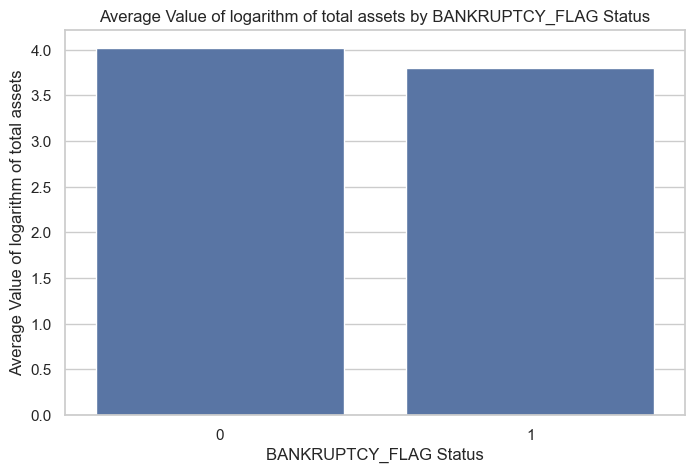

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


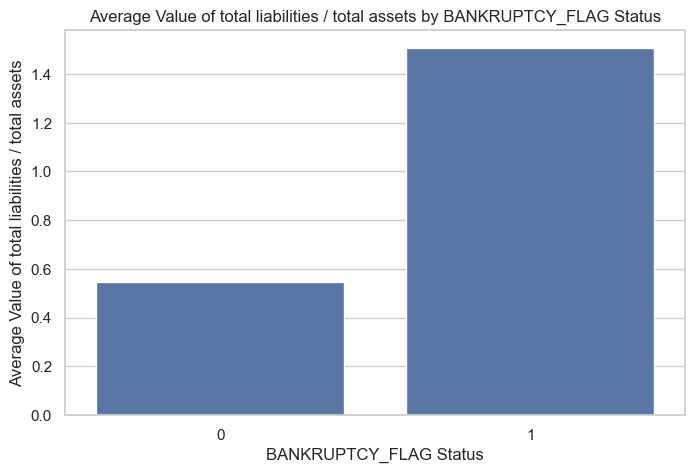

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


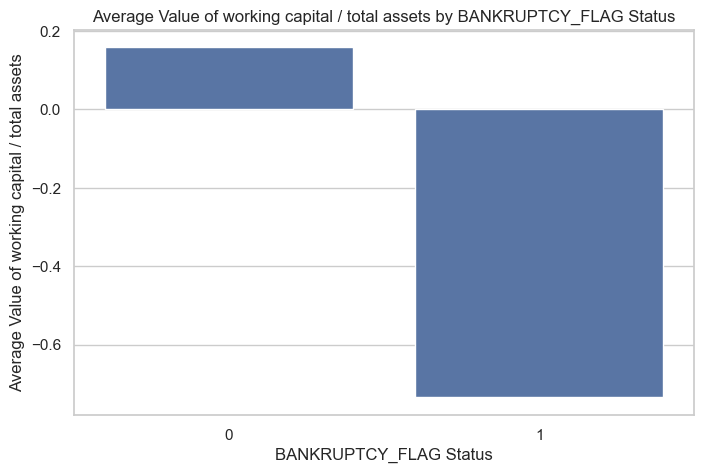

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


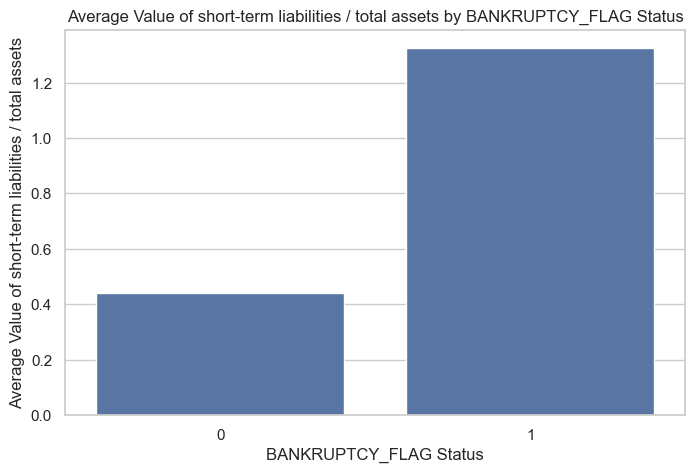

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


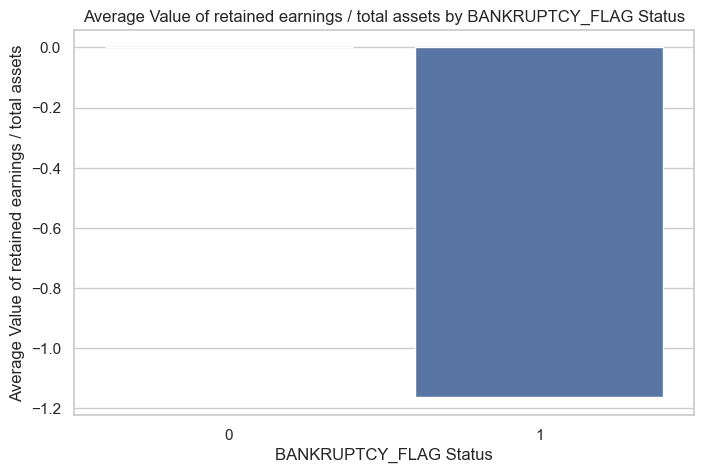

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


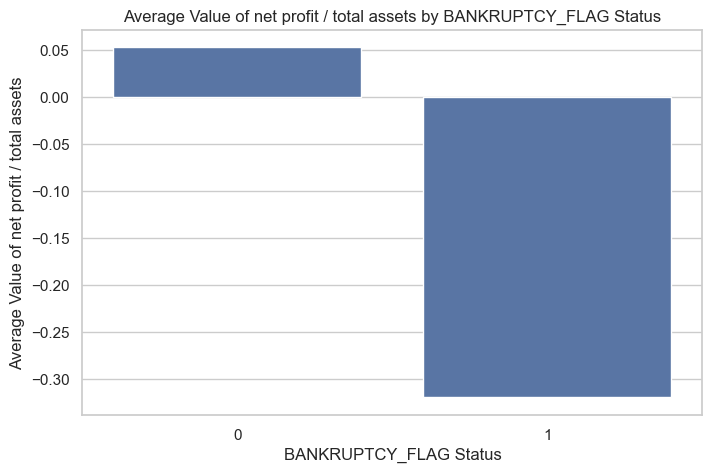

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


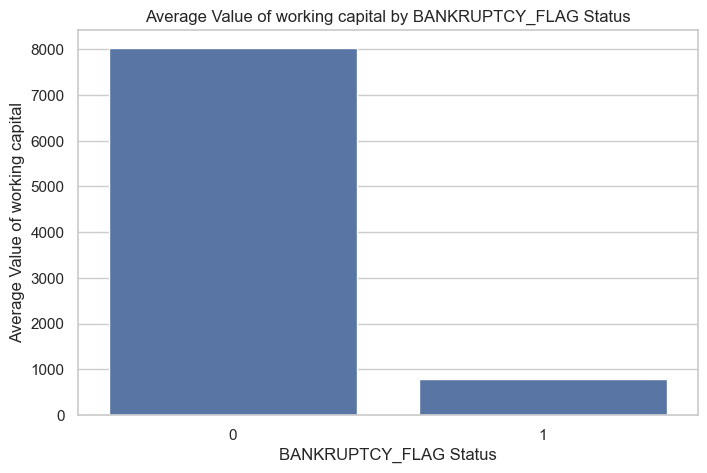

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


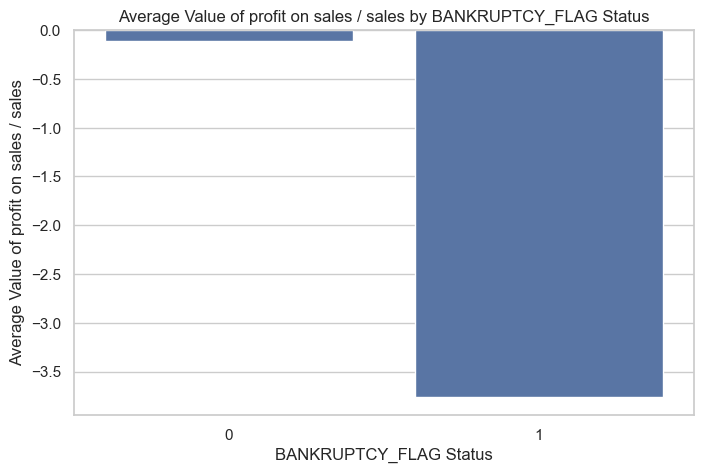

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


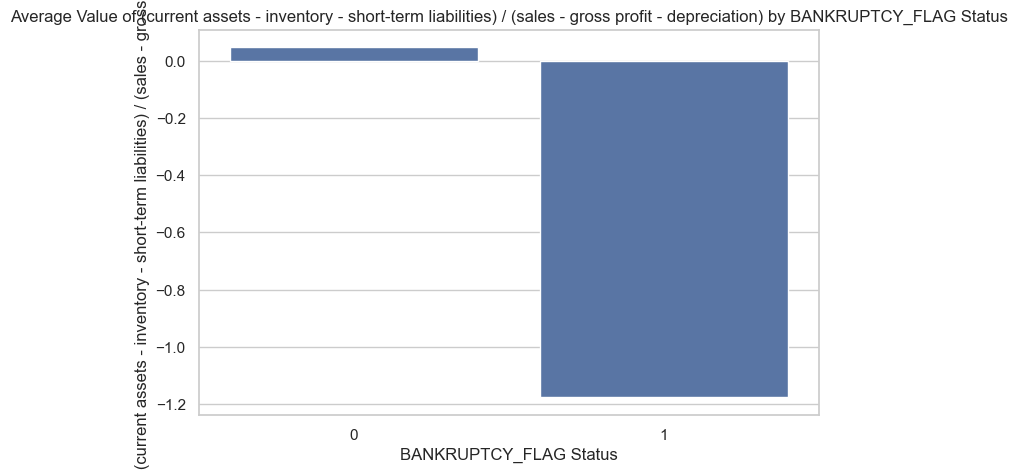

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


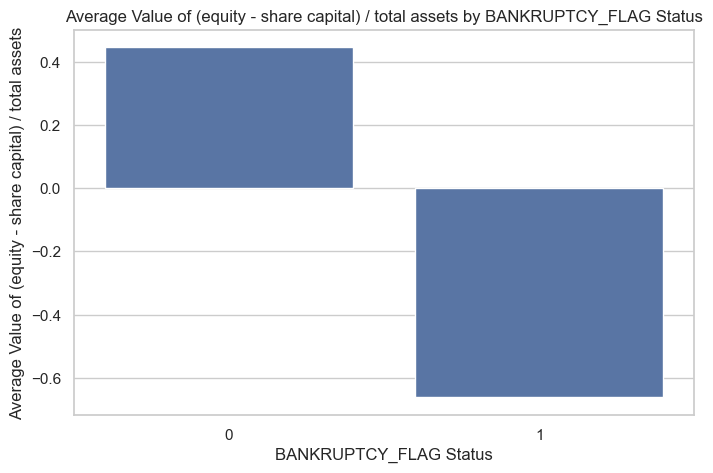

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


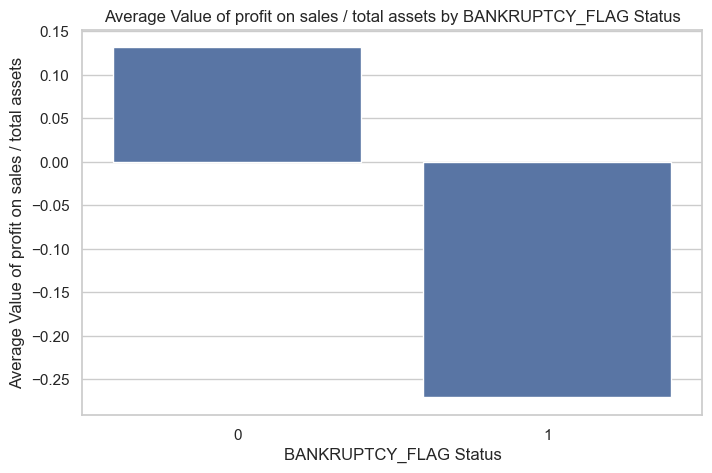

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


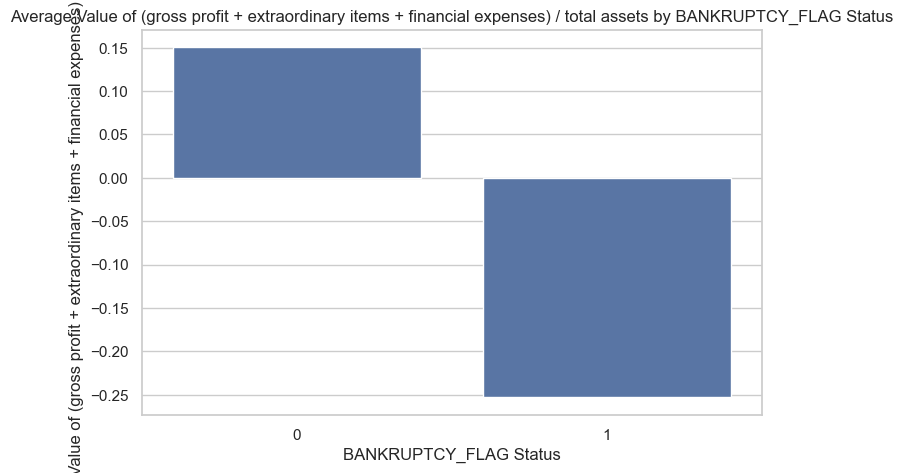

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


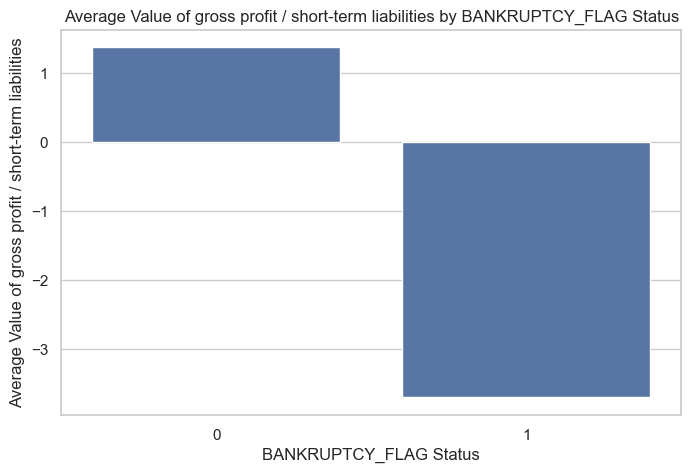

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


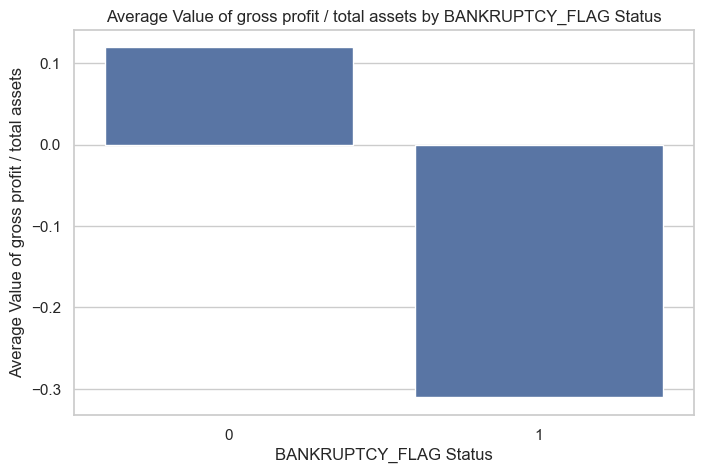

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


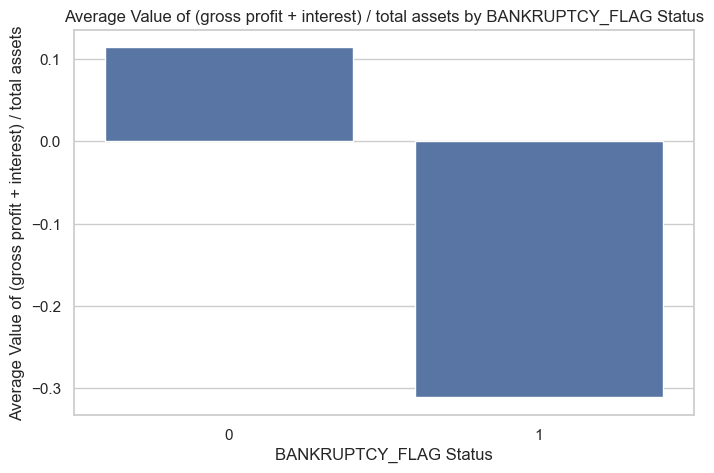

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


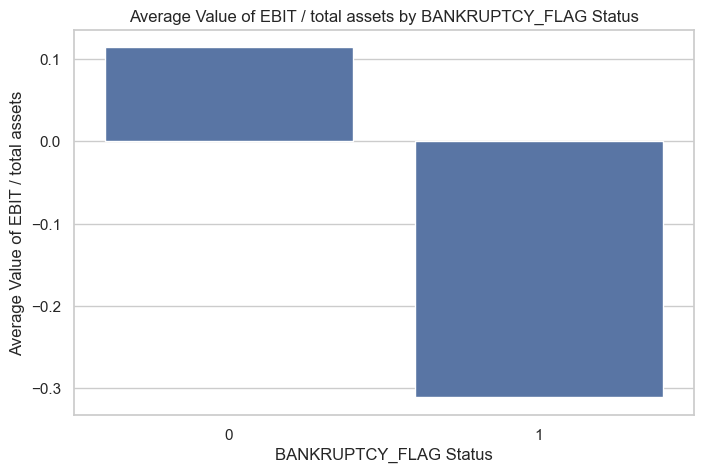

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


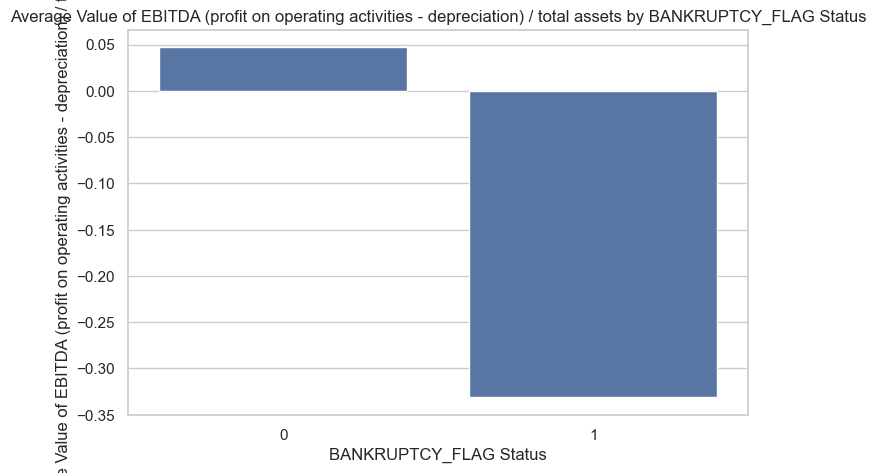

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


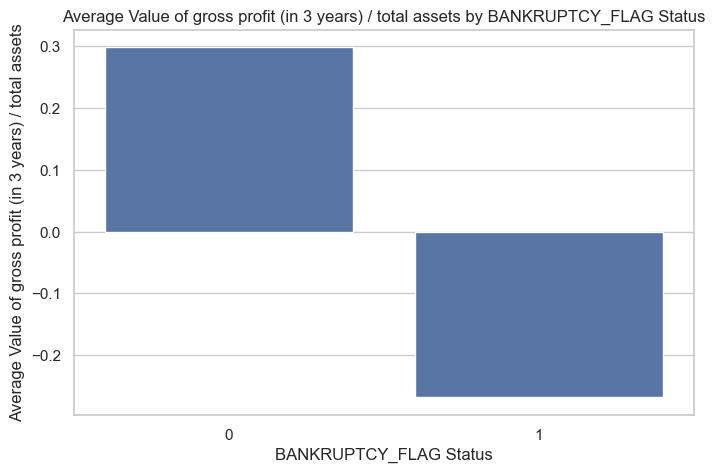

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


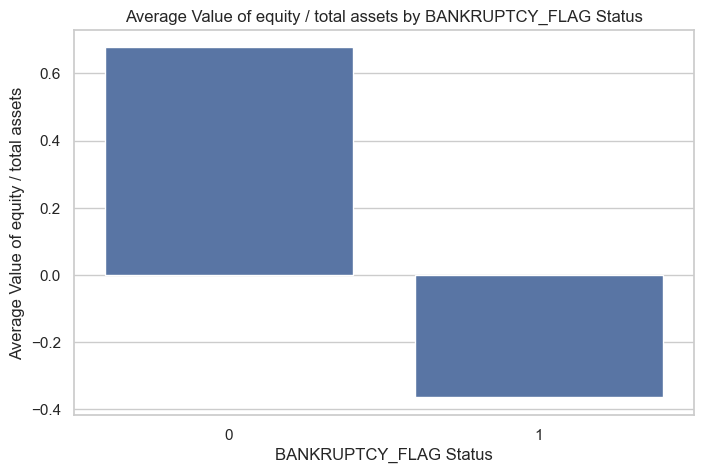

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


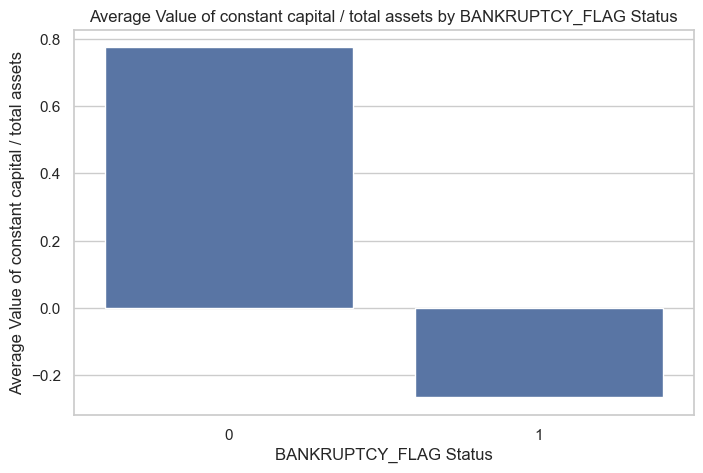

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


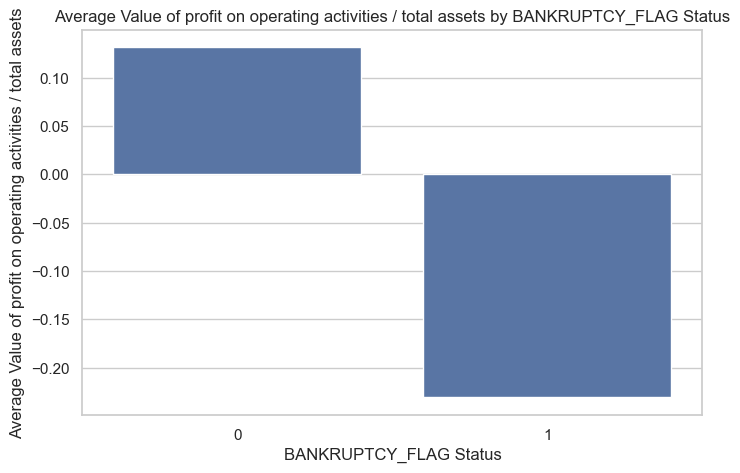

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


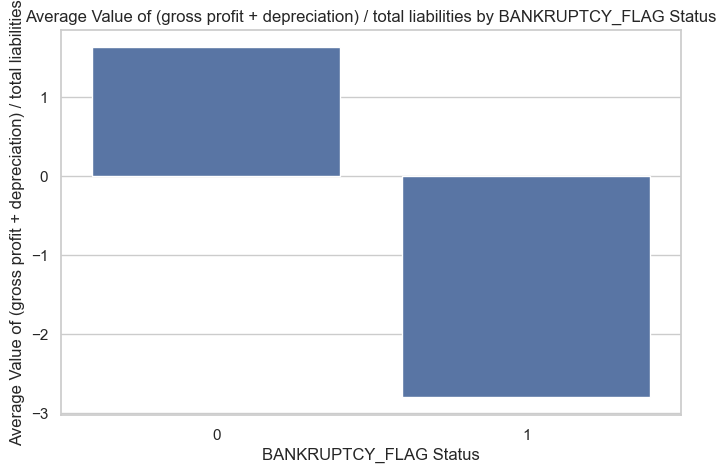

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


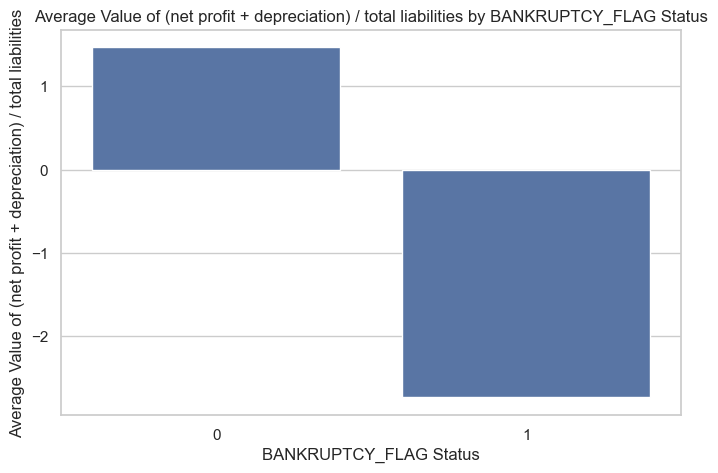

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


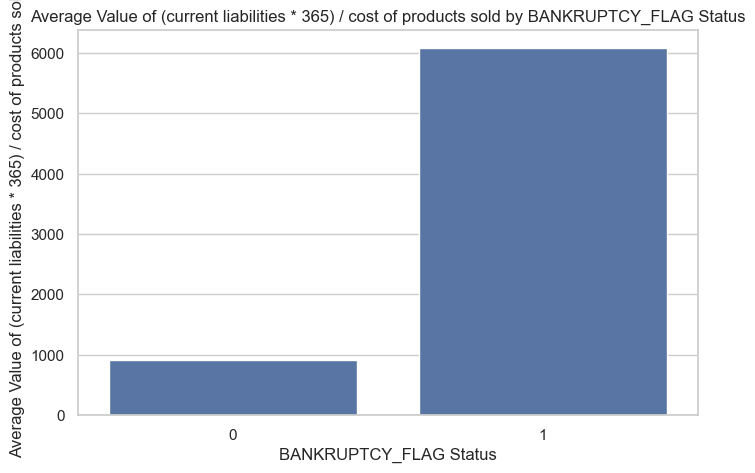

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


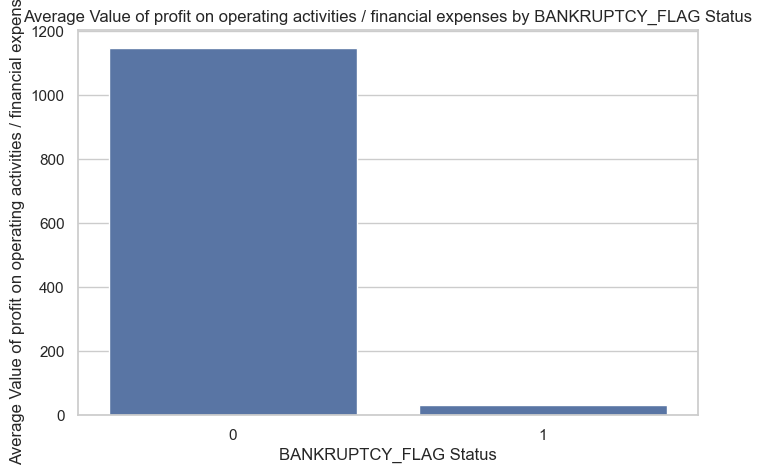

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


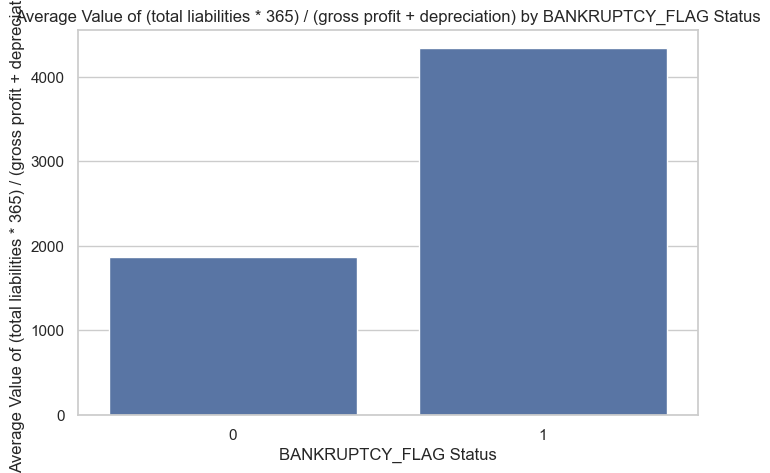

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


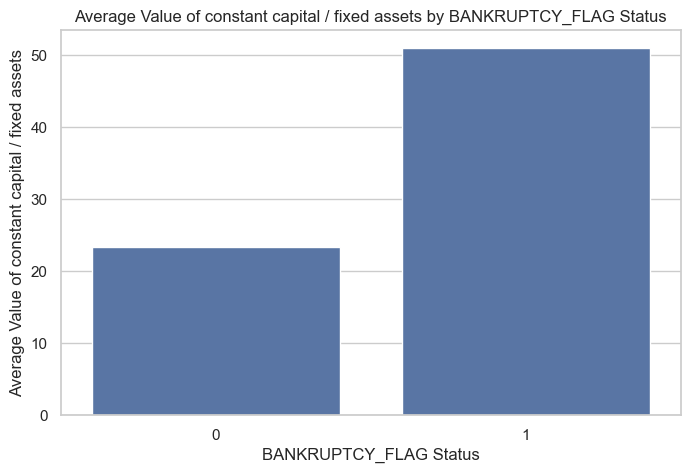

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


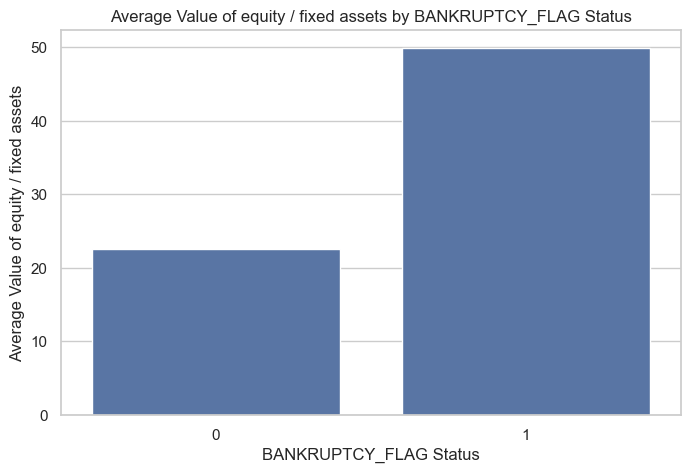

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


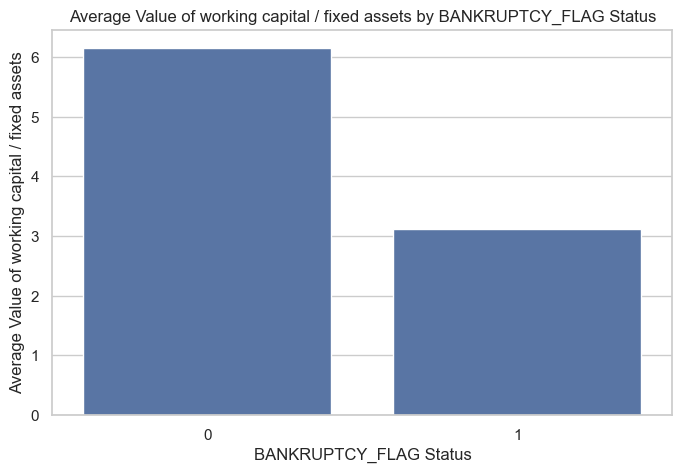

/var/folders/95/sy8w04495wn2w8fdhbld3b200000gn/T/ipykernel_59206/2471435906.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)


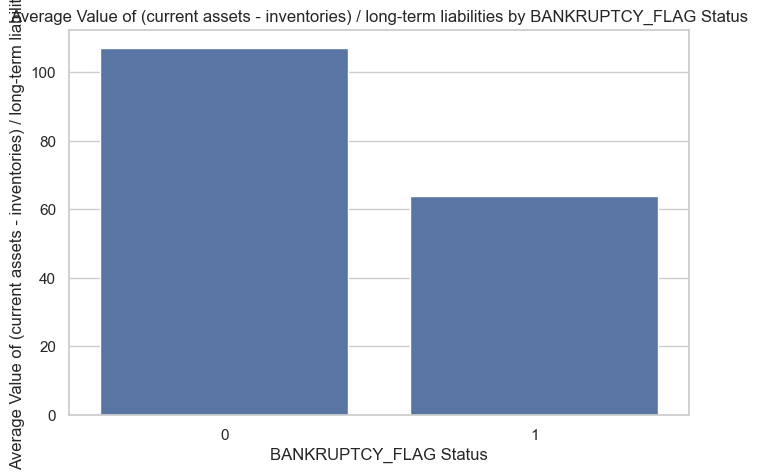

In [12]:

# Assuming df is your DataFrame and 'BANKRUPTCY_FLAG' is your binary target variable
print('Getting point-biserial correlation')

# Select continuous features, excluding the target
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('BANKRUPTCY_FLAG')

# Calculate point-biserial correlation for each feature
correlations = {}
for feature in continuous_features:
    correlation, p_value = stats.pointbiserialr(df[feature], df['BANKRUPTCY_FLAG'])
    correlations[feature] = correlation


# Convert the correlations dictionary to a list of tuples and sort by the absolute correlation value
sorted_features = sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True)

# Take the top n features
n = 30

top_n_features = [feature for feature, correlation in sorted_features[:n]]

# Create a new DataFrame with the top 3 features and the target variable
df_tops = df[top_n_features + ['BANKRUPTCY_FLAG']]

# Display the new DataFrame with the top 3 features
display(df_tops.head())


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Loop through each of the top n features and create a barplot for each
for feature in top_n_features:
    plt.figure(figsize=(8, 5))  # Set the figure size
    sns.barplot(x='BANKRUPTCY_FLAG', y=feature, data=df_tops, ci=None)
    
    # Adding some customizations
    plt.title(f'Average Value of {feature} by BANKRUPTCY_FLAG Status')
    plt.xlabel('BANKRUPTCY_FLAG Status')
    plt.ylabel(f'Average Value of {feature}')
    
    # Show the plot
    plt.show()


## compare difference between 0 and 1

In [14]:
# Assuming 'df_tops' is your DataFrame and it has already been loaded into a pandas DataFrame

# Separate features and the target variable
X = df_tops.drop('BANKRUPTCY_FLAG', axis=1)
y = df_tops['BANKRUPTCY_FLAG']

# Calculate the mean values of features for both groups (BANKRUPTCY_FLAG=0 and BANKRUPTCY_FLAG=1)
grouped = df_tops.groupby('BANKRUPTCY_FLAG')
mean_values = grouped.mean()

# Compute the absolute difference in mean values between the two groups
mean_diff_percentage = (mean_values.diff().iloc[1] / mean_values.iloc[0]) * 100

# Sort the mean differences and retrieve the top N features with the largest difference
top_n = 20
top_n_features = mean_diff_percentage.abs().sort_values(ascending=False).head(top_n).index

# Create a new DataFrame with only the top N features and the BANKRUPTCY_FLAG
df_topn = df_tops.loc[:, top_n_features.tolist() + ['BANKRUPTCY_FLAG']]

# Output the new DataFrame
print("DataFrame with only the top N features and the BANKRUPTCY_FLAG:")
display(df_topn)


DataFrame with only the top N features and the BANKRUPTCY_FLAG:


,retained earnings / total assets,profit on sales / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),EBITDA (profit on operating activities - depreciation) / total assets,net profit / total assets,working capital / total assets,(current liabilities * 365) / cost of products sold,EBIT / total assets,(gross profit + interest) / total assets,gross profit / short-term liabilities,...,profit on sales / total assets,(net profit + depreciation) / total liabilities,profit on operating activities / total assets,(gross profit + depreciation) / total liabilities,(gross profit + extraordinary items + financial expenses) / total assets,(equity - share capital) / total assets,short-term liabilities / total assets,gross profit (in 3 years) / total assets,total liabilities / total assets,BANKRUPTCY_FLAG
0,0.510690,0.141900,0.473950,0.195770,0.202350,0.240380,124.100,0.253660,0.253660,0.545610,...,0.223490,0.494780,0.223490,0.605110,0.253660,0.426950,0.46490,0.631050,0.46500,0
1,-0.000319,0.121460,0.074369,0.036746,0.030073,0.186680,708.740,0.041670,0.041670,0.075493,...,0.039298,0.059639,0.042196,0.079109,0.042199,0.029802,0.55197,0.297857,0.59563,0
2,0.000000,0.164990,0.369210,0.292470,0.257860,0.665190,78.101,0.318770,0.318770,1.064400,...,0.276560,0.901690,0.304660,1.105100,0.324530,0.607750,0.29949,0.297857,0.29949,0
3,0.000000,0.293580,0.706570,0.362700,0.227160,0.042784,201.670,0.285050,0.285050,0.551560,...,0.388740,0.359520,0.379470,0.444840,0.381070,0.309750,0.51680,0.297857,0.67850,0
4,0.187900,0.120810,0.163790,0.157310,0.085443,0.359230,99.090,0.108230,0.108230,0.284520,...,0.188340,0.306200,0.188340,0.366100,0.108230,0.521670,0.38039,0.226020,0.38039,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7022,0.018371,0.007891,0.039866,-0.034360,0.018371,-0.136190,31.645,0.018371,0.018371,0.052828,...,0.032032,0.178790,0.032032,0.178790,0.018371,0.460840,0.34776,0.018371,0.47410,1
7023,-0.013359,-0.007072,-0.040671,-0.069656,-0.013359,-0.022650,93.061,-0.015036,-0.015036,-0.047162,...,-0.008746,0.081486,-0.008746,0.078613,-0.015036,0.328470,0.31882,-0.015036,0.58354,1
7024,0.006338,0.004048,0.012817,-0.026370,0.006338,0.439230,51.443,0.012022,0.012022,0.023912,...,0.014559,0.094015,0.014559,0.105320,0.012022,0.494490,0.50276,0.012022,0.50276,1
7025,0.000000,-0.232720,-0.274290,-0.017463,-0.041643,-0.128520,212.420,-0.036795,-0.036795,-0.121720,...,-0.098064,-0.020947,0.006414,-0.015232,0.006414,0.129780,0.30230,0.045607,0.84810,1


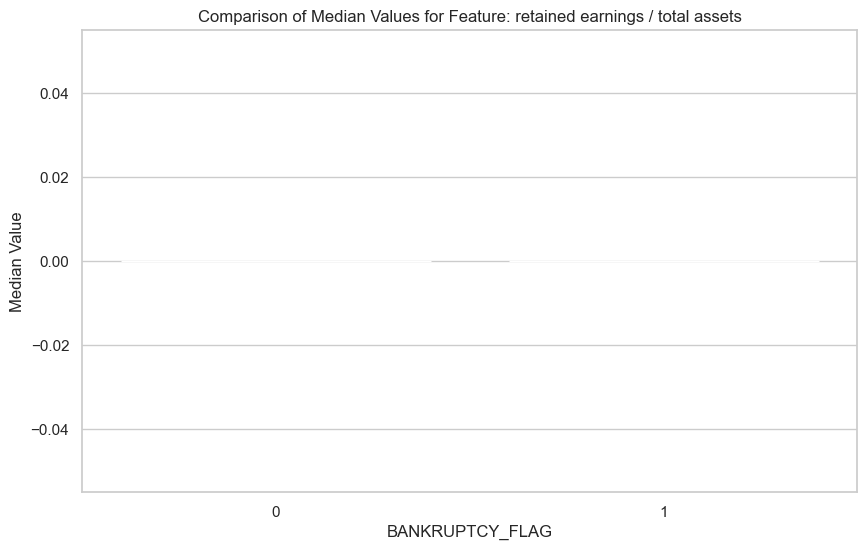

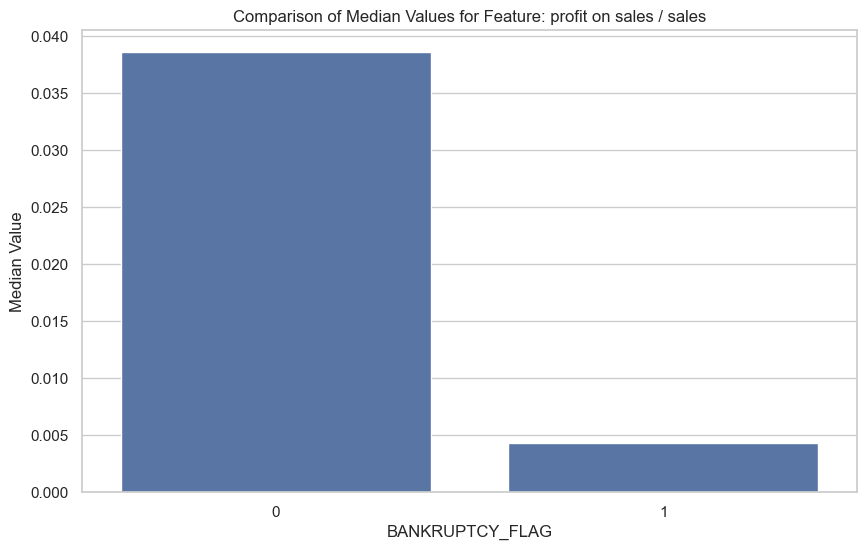

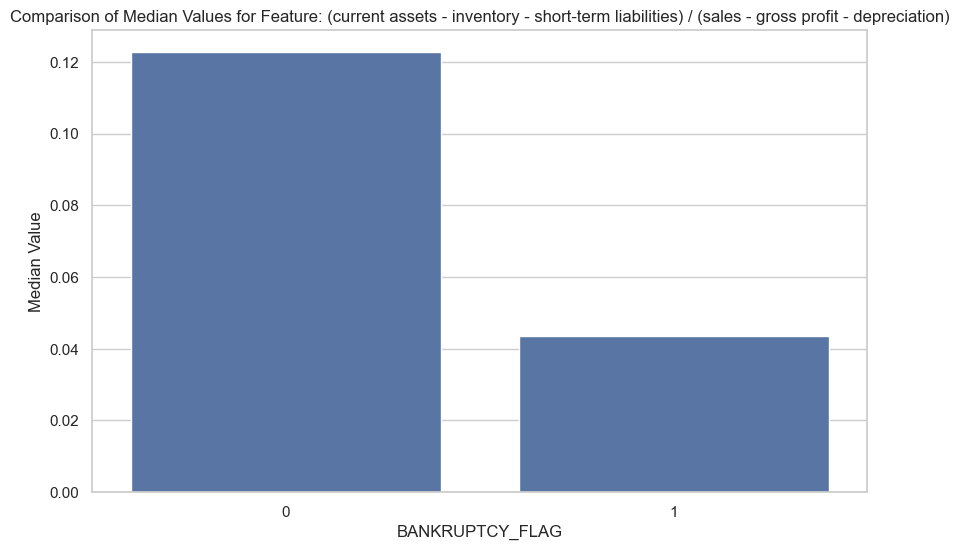

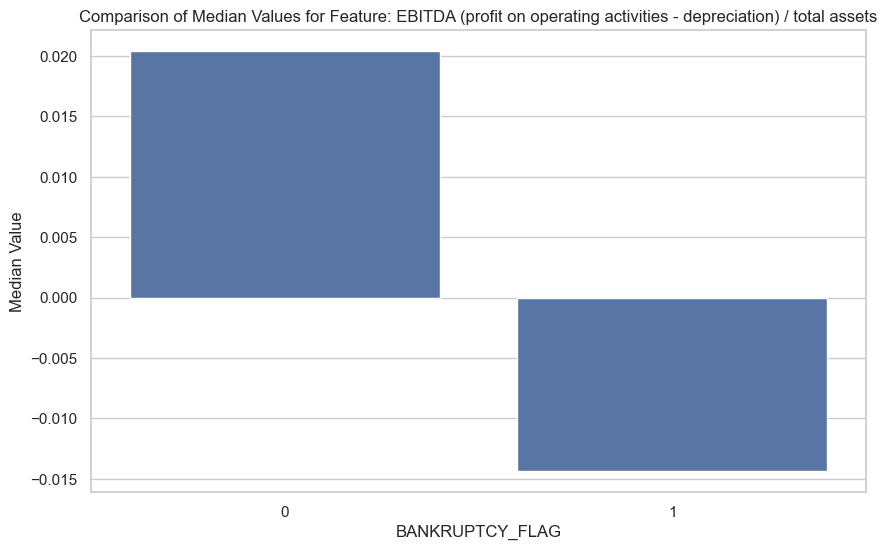

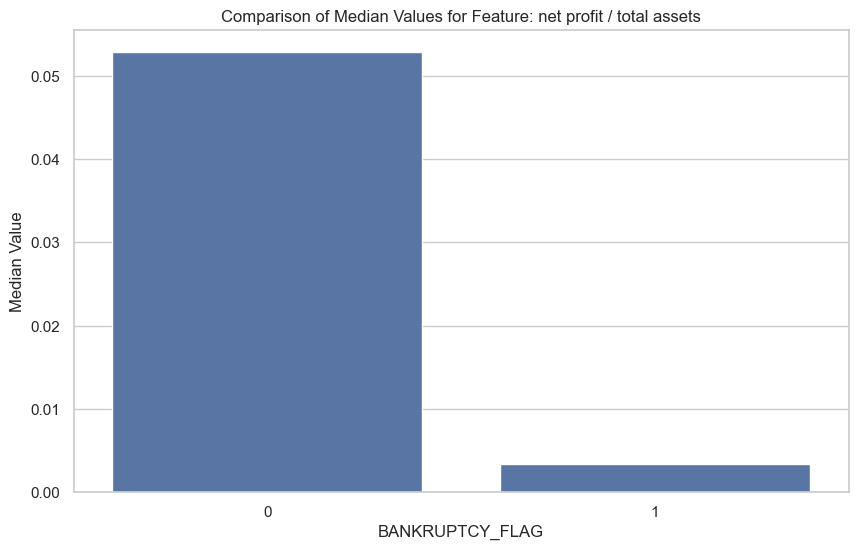

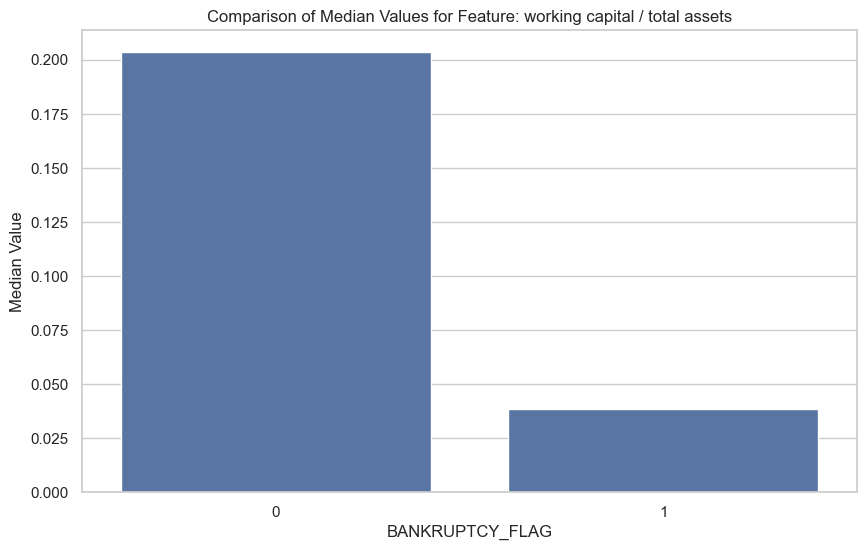

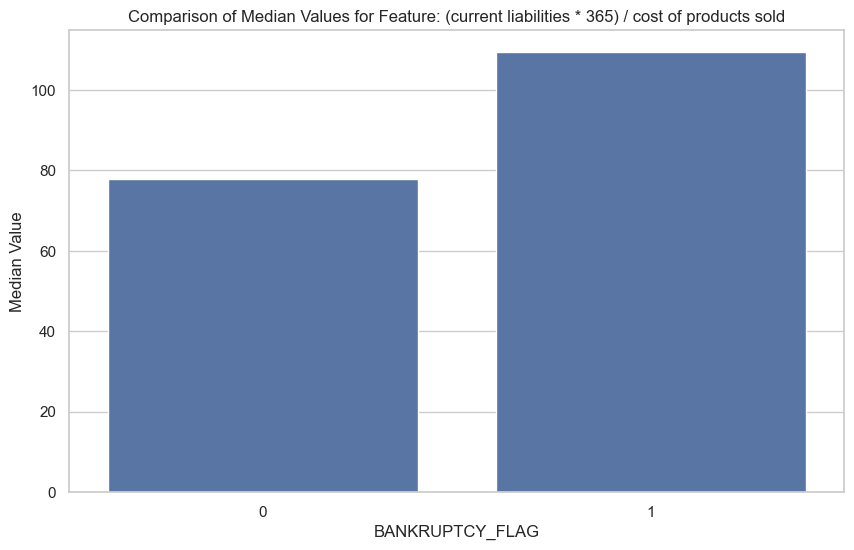

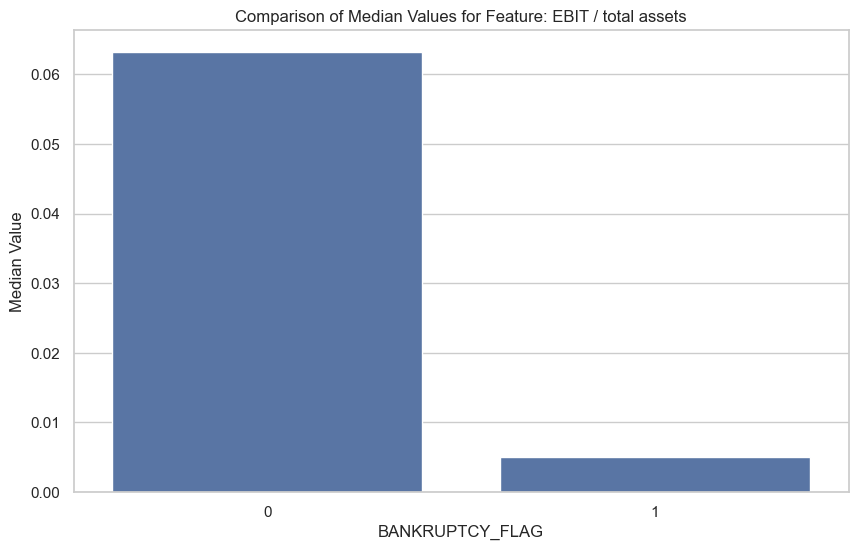

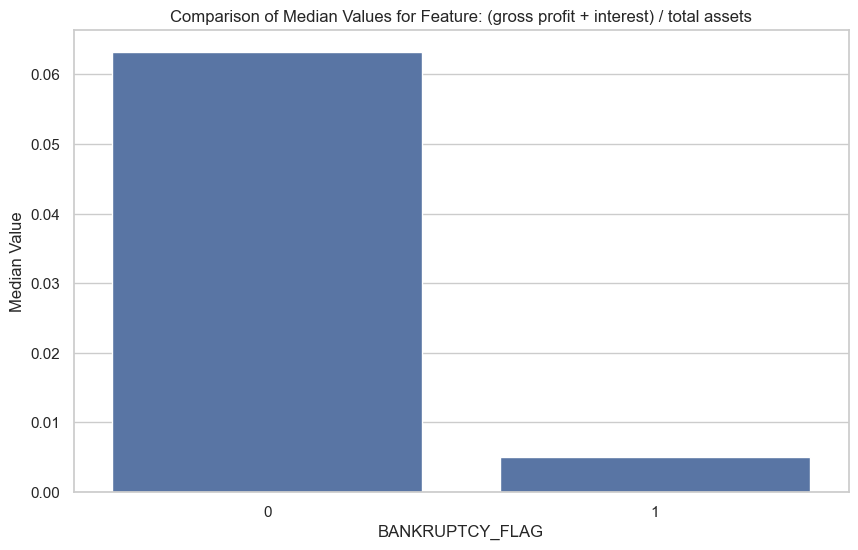

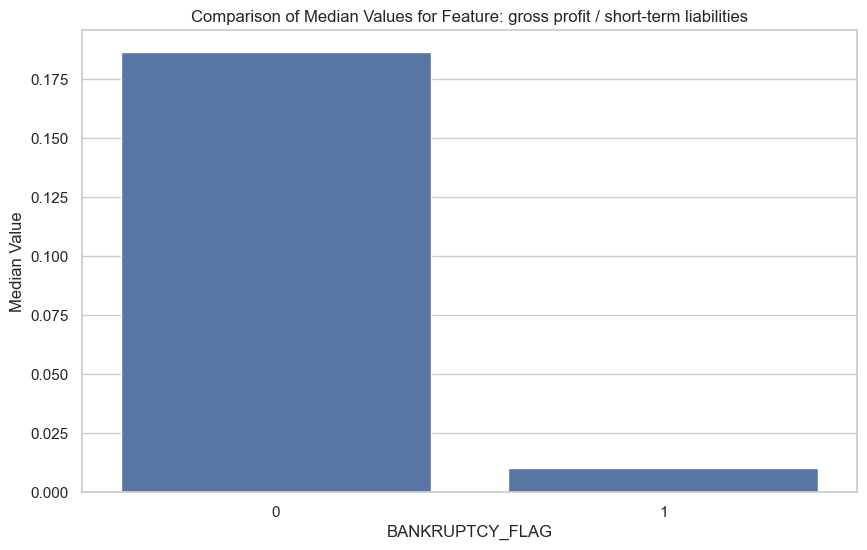

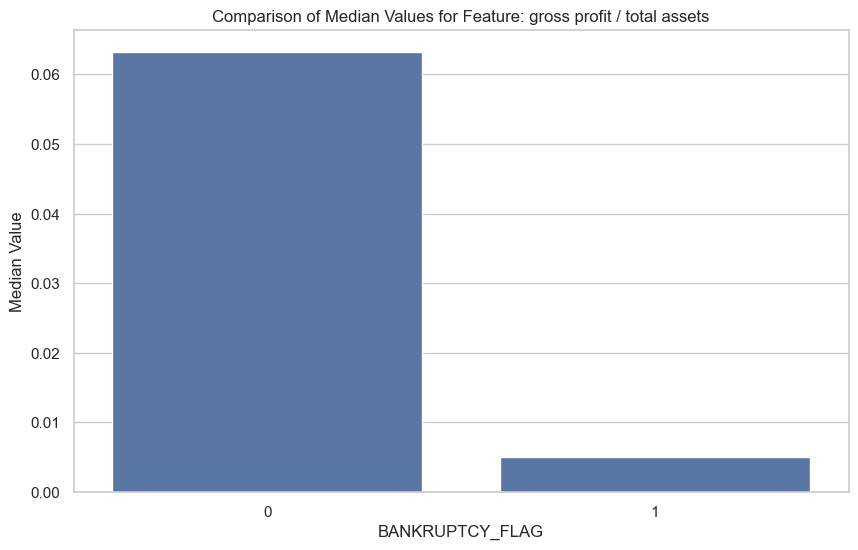

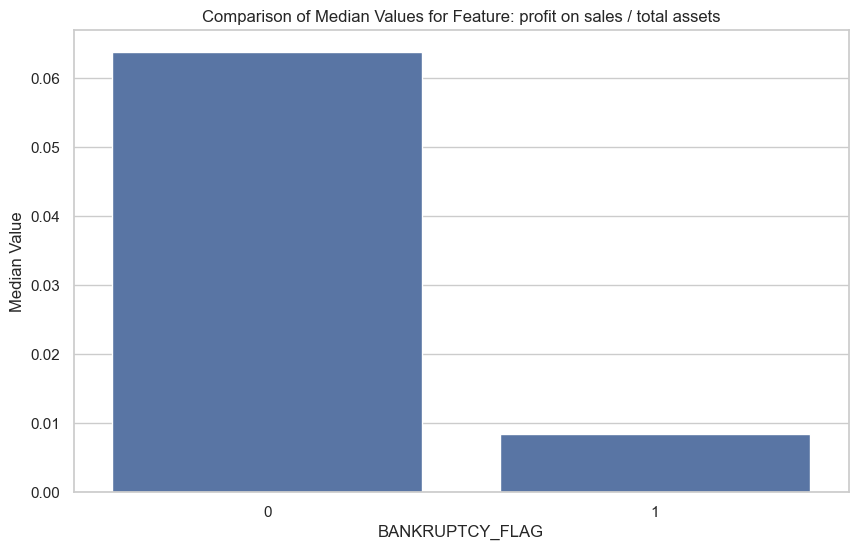

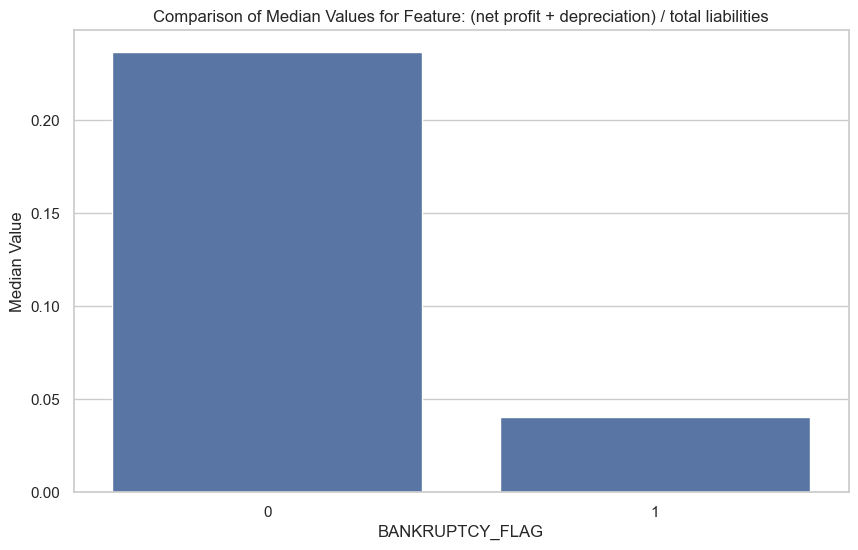

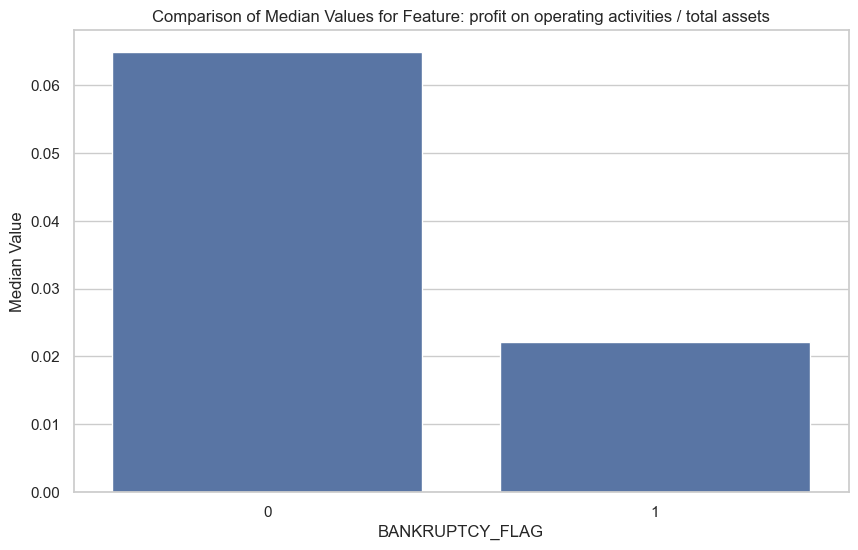

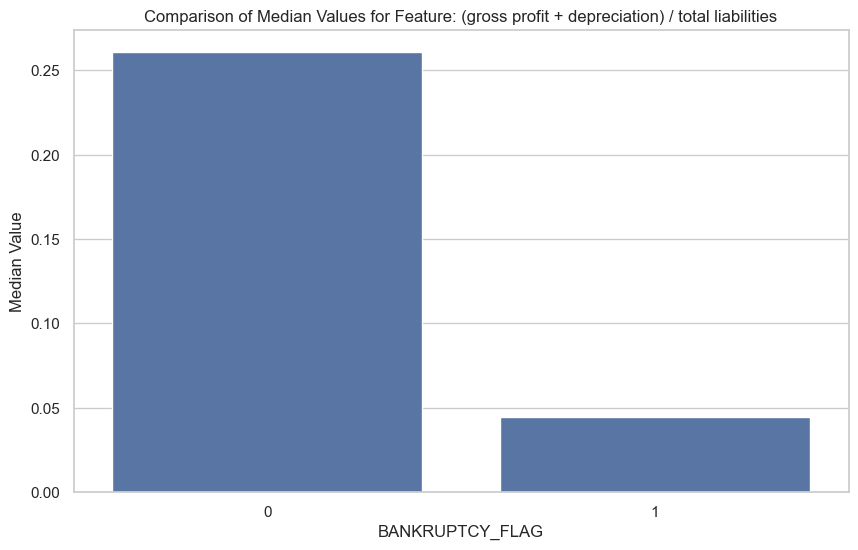

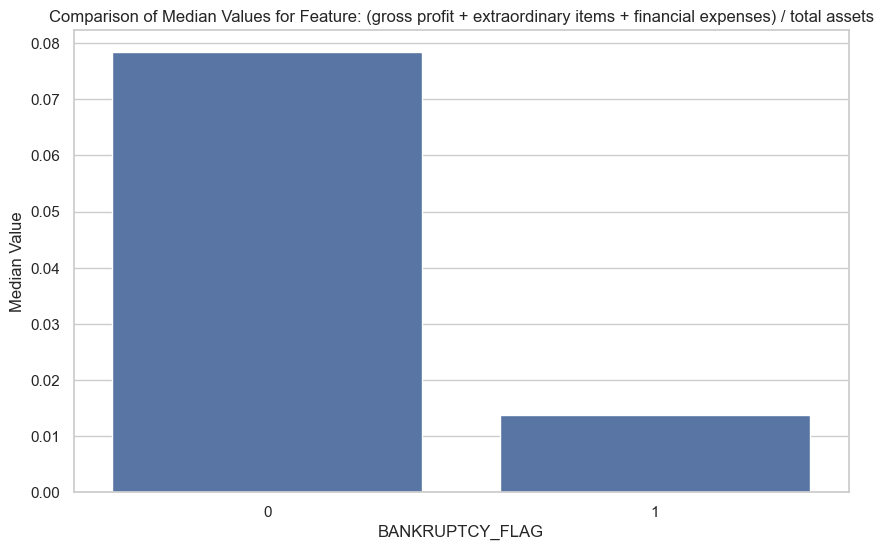

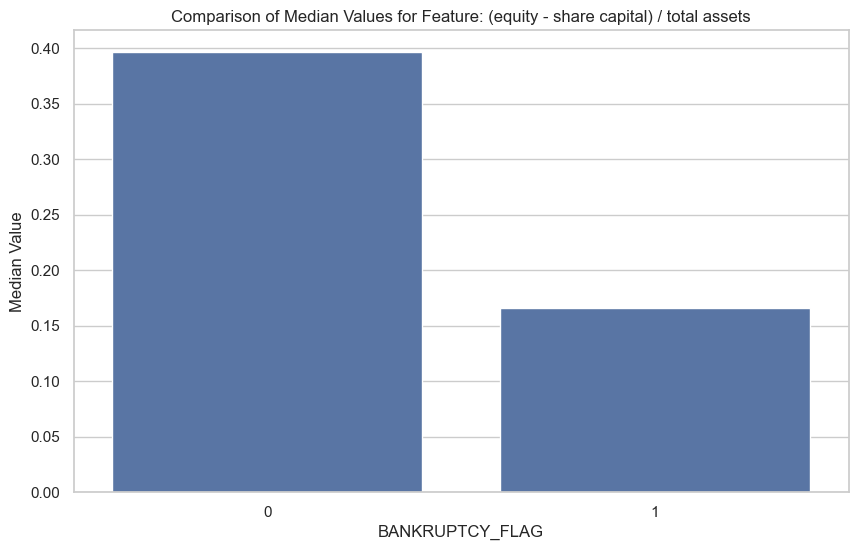

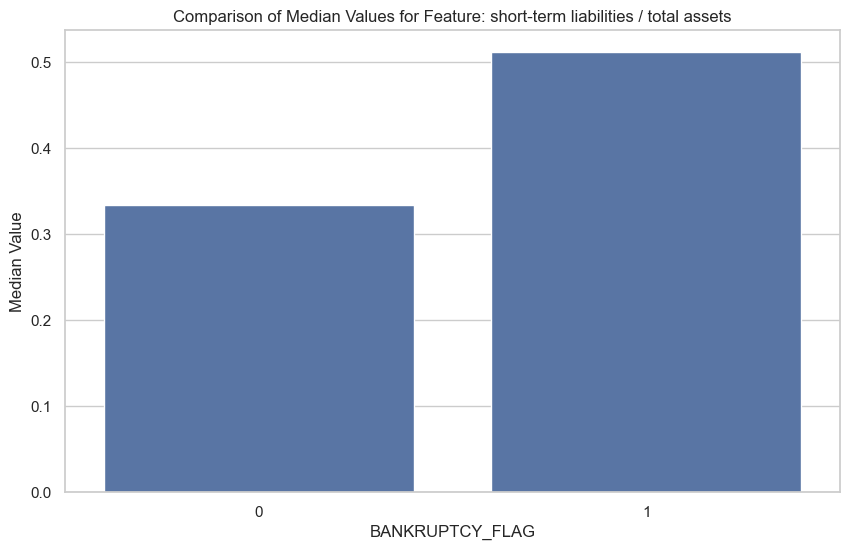

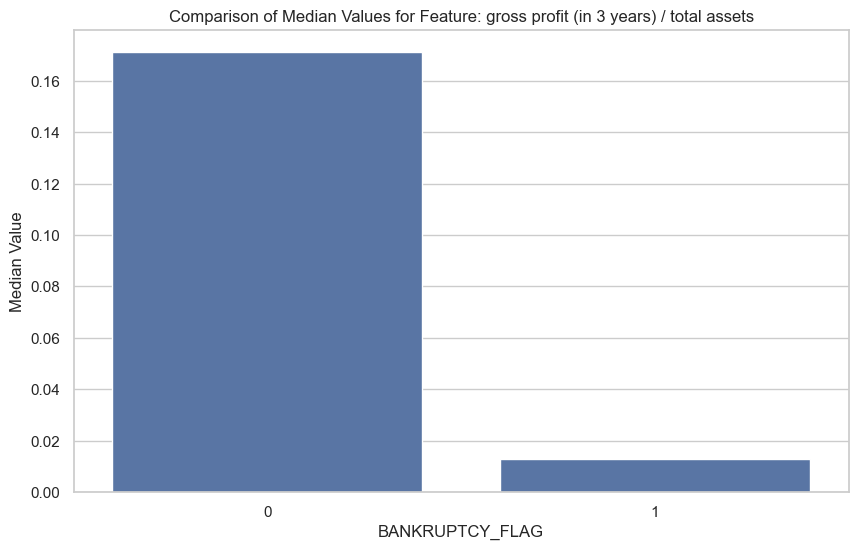

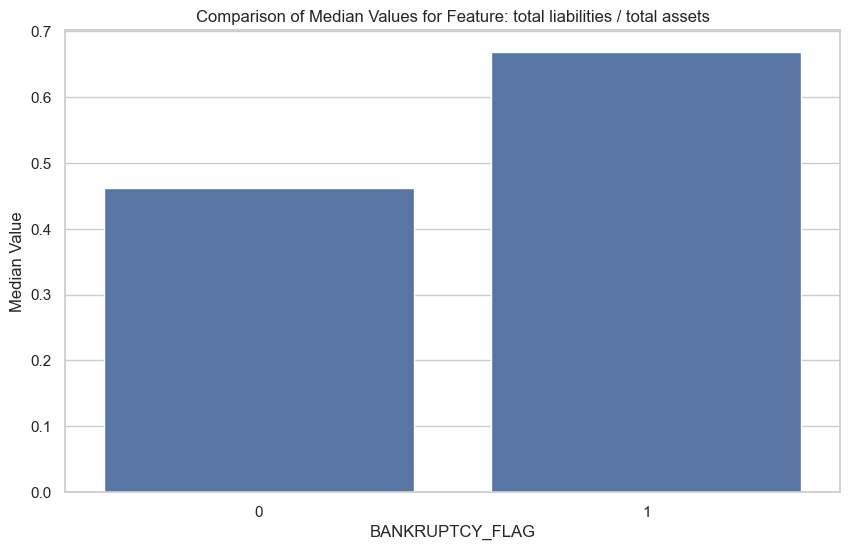

In [15]:
# Calculate the median values of features for both groups (BANKRUPTCY_FLAG=0 and BANKRUPTCY_FLAG=1)
grouped_topn = df_topn.groupby('BANKRUPTCY_FLAG').median()

# Transpose the grouped DataFrame to make plotting easier
grouped_topn = grouped_topn.transpose()

# Reset index to get features as a separate column
grouped_topn = grouped_topn.reset_index()

# Rename the columns for clarity
grouped_topn.columns = ['Feature', 'Median_0', 'Median_1']

# Loop through each feature and create a bar plot
for feature in grouped_topn['Feature']:
    # Create a DataFrame for the current feature
    feature_data = grouped_topn[grouped_topn['Feature'] == feature].melt(id_vars='Feature', 
                                                                         value_vars=['Median_0', 'Median_1'],
                                                                         var_name='BANKRUPTCY_FLAG', 
                                                                         value_name='Median_Value')
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_data, x='BANKRUPTCY_FLAG', y='Median_Value')
    
    # Improve the plot aesthetics
    plt.title(f'Comparison of Median Values for Feature: {feature}')
    plt.xlabel('BANKRUPTCY_FLAG')
    plt.ylabel('Median Value')
    plt.xticks([0, 1], ['0', '1'])  # Set the x-tick labels to be more descriptive
    
    # Show the plot
    plt.show()

In [ ]:
df_topn.to_excel("reduced.xlsx", index=False)


## Models: PCA

In [ ]:
# Flatten the list of all features from the groups
all_features = [feature for group in feature_groups.values() for feature in group]

# Drop rows with NaN values in any of the specified features
df_cleaned = df.dropna(subset=all_features)

# Check the shape of the original and cleaned dataframes
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")
print(f"Number of rows removed: {round((1-df_cleaned.shape[0]/df.shape[0]),4)*100}%")

df_pca = pd.DataFrame(index=df_cleaned.index)

# Initialize PCA with only 1 component for each group
pca = PCA(n_components=1)

# For each group, apply PCA and create a new feature
for group_num, features in feature_groups_reduced.items():
    # Clean the feature names by removing '+' and '-' signs
    cleaned_features = [f.lstrip('+-') for f in features]
    
    # Make sure the DataFrame has the cleaned column names
    df_cleaned.columns = [col.lstrip('+-') for col in df_cleaned.columns]
    
    # Create a combined feature name based on group number
    combined_feature_name = f'combined_feature{group_num}'
    
    # Apply PCA to the cleaned features
    df_pca[combined_feature_name] = pca.fit_transform(df_cleaned[cleaned_features])

# Drop the original features if they are no longer needed
for features in feature_groups_reduced.values():
    cleaned_features = [f.lstrip('+-') for f in features]
    df_cleaned.drop(cleaned_features, axis=1, inplace=True)


df_pca['BANKRUPTCY_FLAG'] = df_cleaned['BANKRUPTCY_FLAG']


In [ ]:
df_pca['BANKRUPTCY_FLAG'] = df_pca['BANKRUPTCY_FLAG'].astype(int)

# Group the data by the 'class' column
grouped = df_pca.groupby('BANKRUPTCY_FLAG')
print(grouped)
# Calculate summary statistics for each group
stats_class_1 = grouped.get_group(0).describe()
stats_class_2 = grouped.get_group(1).describe()

# Calculate the difference in statistics between the two classes
stats_difference = stats_class_1 - stats_class_2

# Display the statistics for class 1
print("Statistics for class 1:")
print(stats_class_1)

# Display the statistics for class 2
print("Statistics for class 2:")
print(stats_class_2)

# Display the difference in statistics
print("Difference in statistics (class 1 - class 2):")
print(stats_difference)


In [ ]:
# Count the number of 0 values
df_topn = df_topn.dropna()
count_zeros = (df_topn['BANKRUPTCY_FLAG'] == 0).sum()

# Count the number of 1 values
count_ones = (df_topn['BANKRUPTCY_FLAG'] == 1).sum()

print(f"Number of 0 values: {count_zeros}")
print(f"Number of 1 values: {count_ones}")

In [16]:
#undersample
# Separate the majority and minority classes
# df_majority = df_pca[df_pca.BANKRUPTCY_FLAG == 0]
# df_minority = df_pca[df_pca.BANKRUPTCY_FLAG == 1]

df_majority = df_topn[df_topn.BANKRUPTCY_FLAG == 0]
df_minority = df_topn[df_topn.BANKRUPTCY_FLAG == 1]


oversample = 'down'

if oversample == 'down':
    # Downsample majority class
    print('downsample')
    df_majority_downsampled = resample(df_majority,
                                    replace=False,                   # sample without replacement
                                    n_samples=len(df_minority),      # to match minority class
                                    random_state=123)                # reproducible results

    # Combine minority class with downsampled majority class
    df_resample = pd.concat([df_majority_downsampled, df_minority])
elif oversample == 'up':
    print('upsample')
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                    replace=True,                     # sample with replacement
                                    n_samples=len(df_majority),       # to match majority class
                                    random_state=123)                 # reproducible results

    # Combine majority class with upsampled minority class
    df_resample = pd.concat([df_majority, df_minority_upsampled])
else:
    print('smote')
    df_resample = df.copy()



# Display new class counts
print(df_resample.BANKRUPTCY_FLAG.value_counts())
# df_original = df_pca.copy()
df_original = df_topn.copy()

# df_pca = df_resample.copy()



downsample
BANKRUPTCY_FLAG
0    2091
1    2091
Name: count, dtype: int64


In [17]:
# Count the number of 0 values
count_zeros = (df_resample['BANKRUPTCY_FLAG'] == 0).sum()

# Count the number of 1 values
count_ones = (df_resample['BANKRUPTCY_FLAG'] == 1).sum()

print(f"Number of 0 values: {count_zeros}")
print(f"Number of 1 values: {count_ones}")

Number of 0 values: 2091
Number of 1 values: 2091


# Simple Model - Regression

### Sampling

In [18]:


# Assuming df_pca is your DataFrame and 'class' is the column with the target variable
# Separate the features and the target variable
X = df_original.drop('BANKRUPTCY_FLAG', axis=1)  # Features
y = df_original['BANKRUPTCY_FLAG']               # Target variable

X_resample = df_resample.drop('BANKRUPTCY_FLAG', axis=1)  # Features
y_resample = df_resample['BANKRUPTCY_FLAG']               # Target variable

# Split the data - 70% for training and 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)


if oversample == 'smote':
    print('smote')
    # Oversample the minority class with SMOTE
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    class_distribution = Counter(y_train)

    print("Before SMOTE:")
    for class_label, count in class_distribution.items():
        print(f"Class {class_label}: {count} samples")

    X_train = X_train_smote
    y_train = y_train_smote
    class_distribution = Counter(y_train_smote)

    print("After SMOTE:")
    for class_label, count in class_distribution.items():
        print(f"Class {class_label}: {count} samples")



In [ ]:
len(X_train),len(X_train_original)

In [19]:
# Split the data into training and test sets


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions on the test data
y_pred_proba = model.predict(X_test_original)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluating the model
print("Classification Report:\n", classification_report(y_test_original, y_pred))

# Calculate accuracy for class 1 (positive class)
accuracy_1 = accuracy_score(y_test_original[y_test_original == 1], y_pred[y_test_original == 1])
print("Accuracy for class 1:", accuracy_1)


# Calculate accuracy for class 0 (negative class)
accuracy_0 = accuracy_score(y_test_original[y_test_original == 0], y_pred[y_test_original == 0])
print("Accuracy for class 0:", accuracy_0)



Epoch 1/10
105/105 [==============================] - 0s 588us/step - loss: 1430.8870 - accuracy: 0.4939
Epoch 2/10
105/105 [==============================] - 0s 463us/step - loss: 1369.5006 - accuracy: 0.4942
Epoch 3/10
105/105 [==============================] - 0s 449us/step - loss: 1303.5895 - accuracy: 0.4939
Epoch 4/10
105/105 [==============================] - 0s 438us/step - loss: 1233.8595 - accuracy: 0.4948
Epoch 5/10
105/105 [==============================] - 0s 431us/step - loss: 1171.7129 - accuracy: 0.4951
Epoch 6/10
105/105 [==============================] - 0s 478us/step - loss: 1102.4172 - accuracy: 0.4954
Epoch 7/10
105/105 [==============================] - 0s 541us/step - loss: 1038.3273 - accuracy: 0.4957
Epoch 8/10
105/105 [==============================] - 0s 532us/step - loss: 971.0687 - accuracy: 0.4966
Epoch 9/10
105/105 [==============================] - 0s 511us/step - loss: 900.1847 - accuracy: 0.4978
Epoch 10/10
272/272 [==============================] - 0s

In [20]:

# Convert the data into TensorFlow Datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

train_data_orignal = tf.data.Dataset.from_tensor_slices((X_train_original, y_train_original)).batch(32)
test_data_orignal = tf.data.Dataset.from_tensor_slices((X_test_original, y_test_original)).batch(32)

# Define the random forest model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
model.fit(train_data, epochs=10)

# Make predictions on the test set
y_pred = model.predict(test_data_orignal)

# Convert predictions to binary values
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Print the classification report
print("Classification Report:\n", classification_report(y_test_original, y_pred_binary))

# Calculate precision for class 0 (negative class)
precision_class_0 = precision_score(y_test_original, y_pred_binary, pos_label=0)
print("Precision for class 0:", precision_class_0)

# Calculate precision for class 1 (positive class)
precision_class_1 = precision_score(y_test_original, y_pred_binary, pos_label=1)
print("Precision for class 1:", precision_class_1)




Epoch 1/10
105/105 [==============================] - 0s 612us/step - loss: 471.6726 - accuracy: 0.4927
Epoch 2/10
105/105 [==============================] - 0s 457us/step - loss: 293.5334 - accuracy: 0.4921
Epoch 3/10
105/105 [==============================] - 0s 427us/step - loss: 120.4909 - accuracy: 0.4747
Epoch 4/10
105/105 [==============================] - 0s 500us/step - loss: 2.8795 - accuracy: 0.4921
Epoch 5/10
105/105 [==============================] - 0s 512us/step - loss: 2.7856 - accuracy: 0.5034
Epoch 6/10
105/105 [==============================] - 0s 547us/step - loss: 2.3509 - accuracy: 0.5058
Epoch 7/10
105/105 [==============================] - 0s 537us/step - loss: 1.9401 - accuracy: 0.5229
Epoch 8/10
105/105 [==============================] - 0s 445us/step - loss: 1.5577 - accuracy: 0.5668
Epoch 9/10
105/105 [==============================] - 0s 451us/step - loss: 1.2287 - accuracy: 0.6245
Epoch 10/10
272/272 [==============================] - 0s 329us/step
Classif

### Decision Tree

In [21]:

# Assuming df_pca is your DataFrame and 'class' is the column with the target variable

# Split the data - 70% for training and 30% for testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42,max_depth=6)

# Fit the model with the training data
decision_tree.fit(X_train, y_train)

# Predictions on the test data
y_pred = decision_tree.predict(X_test_original)

# Evaluating the model
print("Classification Report:\n", classification_report(y_test_original, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_original, y_pred))
print("Accuracy Score:", accuracy_score(y_test_original, y_pred))

# Export the decision tree to a tree.dot file
export_graphviz(decision_tree, out_file='tree.dot', 
                feature_names=X_train.columns,  # replace with your actual feature names
                class_names=['0', '1'],  # replace with your actual class names
                rounded=True, proportion=False, 
                precision=2, filled=False)



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79      8272
           1       0.10      0.77      0.18       409

    accuracy                           0.67      8681
   macro avg       0.54      0.72      0.49      8681
weighted avg       0.94      0.67      0.77      8681

Confusion Matrix:
 [[5515 2757]
 [  93  316]]
Accuracy Score: 0.6716968091233729


In [ ]:
X_train.columns

In [27]:

# Convert the data into TensorFlow Datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Define the random forest model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
model.fit(train_data, epochs=30)

# Make predictions on the test set
y_pred = model.predict(test_data)

# Convert predictions to binary values
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# Calculate precision for class 0 (negative class)
precision_class_0 = precision_score(y_test, y_pred_binary, pos_label=0)
print("Precision for class 0:", precision_class_0)

# Calculate precision for class 1 (positive class)
precision_class_1 = precision_score(y_test, y_pred_binary, pos_label=1)
print("Precision for class 1:", precision_class_1)


Epoch 1/30
105/105 [==============================] - 0s 651us/step - loss: 6.1918 - accuracy: 0.5540
Epoch 2/30
105/105 [==============================] - 0s 453us/step - loss: 2.1195 - accuracy: 0.6227
Epoch 3/30
105/105 [==============================] - 0s 464us/step - loss: 1.0122 - accuracy: 0.5764
Epoch 4/30
105/105 [==============================] - 0s 459us/step - loss: 0.7332 - accuracy: 0.6057
Epoch 5/30
105/105 [==============================] - 0s 473us/step - loss: 0.7310 - accuracy: 0.6377
Epoch 6/30
105/105 [==============================] - 0s 547us/step - loss: 0.7283 - accuracy: 0.6493
Epoch 7/30
105/105 [==============================] - 0s 529us/step - loss: 6.5095 - accuracy: 0.5552
Epoch 8/30
105/105 [==============================] - 0s 643us/step - loss: 10.3439 - accuracy: 0.5420
Epoch 9/30
105/105 [==============================] - 0s 531us/step - loss: 8.5215 - accuracy: 0.5737
Epoch 10/30
105/105 [==============================] - 0s 462us/step - loss: 6.78

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming 'model' is your trained model after fitting with X_train and y_train from the SMOTE oversampling

# Predictions on resampled test set
y_test_pred_resample = decision_tree.predict(X_test)

# Predictions on original test set
y_test_pred_original = decision_tree.predict(X_test_original)

# Evaluation on resampled test set
resampled_test_classification_report = classification_report(y_test, y_test_pred_resample)
resampled_test_confusion_matrix = confusion_matrix(y_test, y_test_pred_resample)
resampled_test_accuracy_score = accuracy_score(y_test, y_test_pred_resample)

# Evaluation on original test set
original_test_classification_report = classification_report(y_test_original, y_test_pred_original)
original_test_confusion_matrix = confusion_matrix(y_test_original, y_test_pred_original)
original_test_accuracy_score = accuracy_score(y_test_original, y_test_pred_original)

# Output results for resampled test set
print("Resampled Test set classification report:")
print(resampled_test_classification_report)
print("Resampled Test set confusion matrix:")
print(resampled_test_confusion_matrix)
print("Resampled Test set accuracy score:")
print(resampled_test_accuracy_score)

# Output results for original test set
print("Original Test set classification report:")
print(original_test_classification_report)
print("Original Test set confusion matrix:")
print(original_test_confusion_matrix)
print("Original Test set accuracy score:")
print(original_test_accuracy_score)


Resampled Test set classification report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       448
           1       0.68      0.73      0.70       389

    accuracy                           0.71       837
   macro avg       0.71      0.71      0.71       837
weighted avg       0.72      0.71      0.71       837

Resampled Test set confusion matrix:
[[312 136]
 [104 285]]
Resampled Test set accuracy score:
0.7132616487455197
Original Test set classification report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79      8272
           1       0.10      0.77      0.18       409

    accuracy                           0.67      8681
   macro avg       0.54      0.72      0.49      8681
weighted avg       0.94      0.67      0.77      8681

Original Test set confusion matrix:
[[5515 2757]
 [  93  316]]
Original Test set accuracy score:
0.6716968091233729


### Random forest

In [29]:

# Define the parameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
# param_grid = {
#     'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],  
#     'min_samples_split': [2, 5, 8, 10, 12, 14],  
#     'min_samples_leaf': [1, 2, 3, 4],  
#     'criterion': ['gini', 'entropy'],
#     'max_features': ['auto', 'sqrt', 'log2']  
# }
# Initialize the Grid Search with cross-validation
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
y_pred_best = grid_search.best_estimator_.predict(X_test)

# After fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best estimator and its parameters
print("Best estimator found by grid search:")
print(grid_search.best_estimator_)

# Use the best estimator to make predictions
y_pred_best = grid_search.best_estimator_.predict(X_test_original)

# Evaluate the best model
print("Classification Report for the best estimator:\n", classification_report(y_test_original, y_pred_best))
print("Confusion Matrix for the best estimator:\n", confusion_matrix(y_test_original, y_pred_best))
print("Accuracy Score for the best estimator:", accuracy_score(y_test_original, y_pred_best))



Best parameters found:  {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best estimator found by grid search:
DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=42)
Classification Report for the best estimator:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      8272
           1       0.12      0.77      0.21       409

    accuracy                           0.72      8681
   macro avg       0.55      0.75      0.52      8681
weighted avg       0.94      0.72      0.80      8681

Confusion Matrix for the best estimator:
 [[5947 2325]
 [  93  316]]
Accuracy Score for the best estimator: 0.7214606612141459
